# Imports

In [4]:
from diffusion_imaging.handlers import HCPLocalHandler
from diffusion_imaging.models import FreeWaterTensorModel
from diffusion_imaging.preprocessing import PreprocessContainer

# Load files

In [5]:
dwi_file = "D:\\Users\\boywi\\Downloads\\Diffusion"

config = {
    'patient_directory': dwi_file
}
h = HCPLocalHandler(config=config)
patients = h.load()

100206
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_LR.bval
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_LR.bvec
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_LR.nii.gz
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_RL.bval
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_RL.bvec
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_RL.nii.gz
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir96_LR.bval
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir96_LR.bvec
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir96_LR.nii.gz


KeyboardInterrupt: 

# Preprocess

In [ ]:
masker = PreprocessContainer.mask()

for patient in patients:
    for i, mri in enumerate(patient.mri_list):
        patient.mri_list[i].mask = masker.process(mri.data)
        

# Fit model for each mri

In [2]:
for patient in patients:
    for i, mri in enumerate(patient.mri_list):
        fwdtimodel = FreeWaterTensorModel(mri.gradient_table)
        fwdtifit = fwdtimodel.fit(mri.data, mri.mask)
        patient.mri_list[i].fitted_model = fwdtifit

100206
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_LR.bval
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_LR.bvec
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_LR.nii.gz
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_RL.bval
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_RL.bvec
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir95_RL.nii.gz
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir96_LR.bval
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir96_LR.bvec
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir96_LR.nii.gz
D:\Users\boywi\Downloads\Diffusion\100206\unprocessed\3T\Diffusion\100206_3T_DWI_dir96_RL.bval
D:\Users\boywi\Downloads\Diffusion\10

NameError: name 'np' is not defined

# Show stuff

AttributeError: 'FreeWaterTensorFit' object has no attribute 'T'

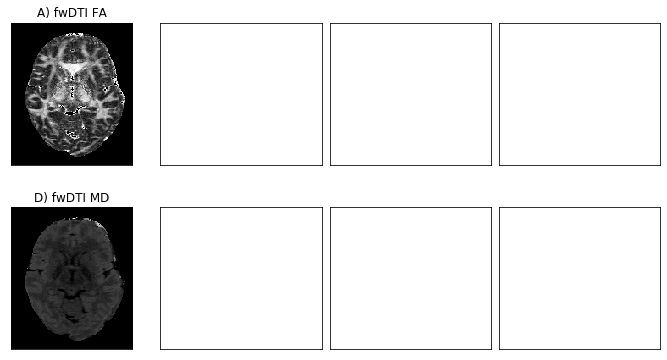

In [21]:
fig1, ax = plt.subplots(2, 4, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[0].set_title('A) fwDTI FA')

"""
ax.flat[1].imshow(dti_FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[1].set_title('B) standard DTI FA')

FAdiff = abs(FA[:, :, axial_slice] - dti_FA[:, :, axial_slice])
ax.flat[2].imshow(FAdiff.T, cmap='gray', origin='lower', vmin=0, vmax=1)
ax.flat[2].set_title('C) FA difference')

ax.flat[3].axis('off')

"""

ax.flat[4].imshow(MD[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[4].set_title('D) fwDTI MD')

"""
ax.flat[5].imshow(dti_MD[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[5].set_title('E) standard DTI MD')


MDdiff = abs(MD[:, :, axial_slice] - dti_MD[:, :, axial_slice])
ax.flat[6].imshow(MDdiff.T, origin='lower', cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[6].set_title('F) MD difference')

"""
F = fwdtifit.f

ax.flat[7].imshow(F[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[7].set_title('G) free water volume')

plt.show()